In [101]:
import numpy as np
import os
import seaborn as sns
import scipy.stats as stat
import pandas as pd
import matplotlib.pyplot as plt
from pydataset import data
import warnings
warnings.filterwarnings("ignore")
import acquire as acq
import prepare as prep
from sklearn.tree import DecisionTreeClassifier

**Using the titanic data, in your classification-exercises repository, create a notebook, decision_tree.ipynb where you will do the following:

In [102]:
titanic_query = "select * from passengers"
directory = os.getcwd()

In [103]:
#prep data
titanic_df = acq.get_titanic_data(titanic_query)
titanic_df['survived'] = titanic_df['survived'].astype(str) #should have dropped embark, and passenger_id so I didn't have to deal with it later
titanic_df.head()

,Unnamed: 0,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [104]:
#clean my data
titanic_df = prep.prep_titanic(titanic_df)
titanic_df.head()

,passenger_id,survived,pclass,sex,sibsp,parch,fare,embarked,alone,sex_male,embarked_Q,embarked_S
0,0,0,3,male,1,0,7.2500,S,0,1,0,1
1,1,1,1,female,1,0,71.2833,C,0,0,0,0
2,2,1,3,female,0,0,7.9250,S,1,0,0,1
3,3,1,1,female,1,0,53.1000,S,0,0,0,1
4,4,0,3,male,0,0,8.0500,S,1,1,0,1


In [105]:
#split my data
train, validate, test = prep.split_data(titanic_df, 'survived')

In [106]:
train.head()

,passenger_id,survived,pclass,sex,sibsp,parch,fare,embarked,alone,sex_male,embarked_Q,embarked_S
455,455,1,3,male,0,0,7.8958,C,1,1,0,0
380,380,1,1,female,0,0,227.5250,C,1,0,0,0
492,492,0,1,male,0,0,30.5000,S,1,1,0,1
55,55,1,1,male,0,0,35.5000,S,1,1,0,1
243,243,0,3,male,0,0,7.1250,S,1,1,0,1


What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). 

When you make those predictions, what is your accuracy? This is your baseline accuracy.

In [107]:
train.head()

,passenger_id,survived,pclass,sex,sibsp,parch,fare,embarked,alone,sex_male,embarked_Q,embarked_S
455,455,1,3,male,0,0,7.8958,C,1,1,0,0
380,380,1,1,female,0,0,227.5250,C,1,0,0,0
492,492,0,1,male,0,0,30.5000,S,1,1,0,1
55,55,1,1,male,0,0,35.5000,S,1,1,0,1
243,243,0,3,male,0,0,7.1250,S,1,1,0,1


In [108]:
#find most common survived or not survived
train.survived.value_counts()

0    329
1    205
Name: survived, dtype: int64

In [109]:
#calculate baseline accuracy
baseline_accuracy = 329 / (329+205)
baseline_accuracy

0.6161048689138576

Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

In [110]:
train.head()

,passenger_id,survived,pclass,sex,sibsp,parch,fare,embarked,alone,sex_male,embarked_Q,embarked_S
455,455,1,3,male,0,0,7.8958,C,1,1,0,0
380,380,1,1,female,0,0,227.5250,C,1,0,0,0
492,492,0,1,male,0,0,30.5000,S,1,1,0,1
55,55,1,1,male,0,0,35.5000,S,1,1,0,1
243,243,0,3,male,0,0,7.1250,S,1,1,0,1


In [129]:
X_train = train.iloc[:, [2] + list(range(4, 7)) + list(range(8, 12))]
X_validate = validate.iloc[:, [2] + list(range(4, 7)) + list(range(8, 12))]
X_test = test.iloc[:, [2] + list(range(4, 7)) + list(range(8, 12))]

In [176]:
X_train.head()

,pclass,sibsp,parch,fare,alone,sex_male,embarked_Q,embarked_S
455,3,0,0,7.8958,1,1,0,0
380,1,0,0,227.5250,1,0,0,0
492,1,0,0,30.5000,1,1,0,1
55,1,0,0,35.5000,1,1,0,1
243,3,0,0,7.1250,1,1,0,1


In [114]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 455 to 496
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      534 non-null    int64  
 1   sibsp       534 non-null    int64  
 2   parch       534 non-null    int64  
 3   fare        534 non-null    float64
 4   alone       534 non-null    int64  
 5   sex_male    534 non-null    uint8  
 6   embarked_Q  534 non-null    uint8  
 7   embarked_S  534 non-null    uint8  
dtypes: float64(1), int64(4), uint8(3)
memory usage: 26.6 KB


In [131]:
#set target
target = 'survived'

In [132]:
#notice im sending in a single column name
y_train = train[target]
y_train.head()

455    1
380    1
492    0
55     1
243    0
Name: survived, dtype: object

In [133]:
#repeat for validate and test
y_validate = validate[target]
y_test = test[target]

In [134]:
clf = DecisionTreeClassifier()
clf

DecisionTreeClassifier()

In [135]:
# fit it!
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [136]:
clf.score(X_train,y_train)

0.9456928838951311

In [137]:
from sklearn.tree import plot_tree

In [138]:
clf.classes_

array(['0', '1'], dtype=object)

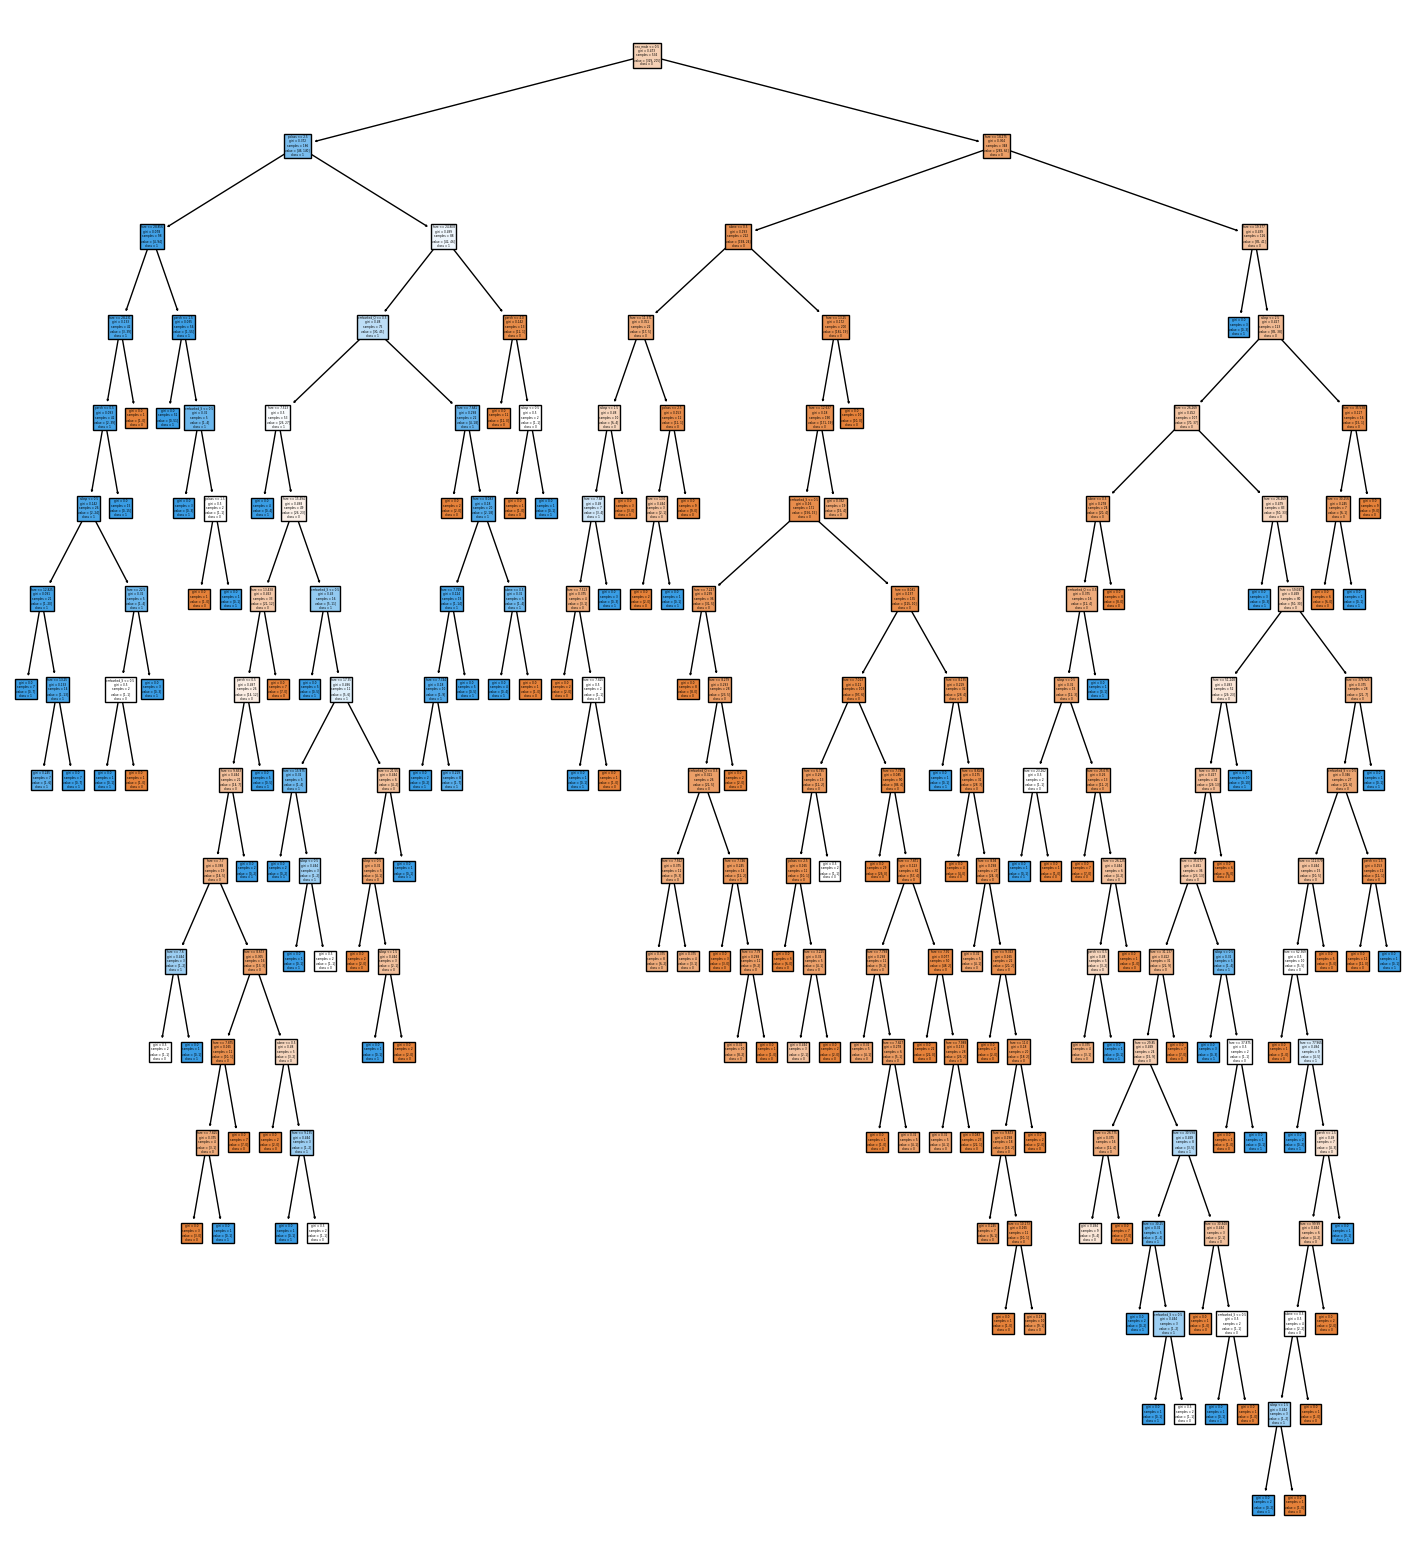

In [139]:
#see the tree that was built
#plot_tree
plt.figure(figsize=(18,20))
plot_tree(clf, #our fitted object
         feature_names=X_train.columns, #puts in our features for the questions
          class_names=clf.classes_, #enters the selected class
          filled=True #colors our leaves and branches based on the class
         )
plt.show()

In [140]:
clf.score(X_validate, y_validate)

0.7303370786516854

Evaluate your in-sample results using the model score, confusion matrix, and classification report.

In [153]:
#set max depth
tree1 = DecisionTreeClassifier(max_depth=8)
tree1

DecisionTreeClassifier(max_depth=8)

In [154]:
tree1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8)

In [155]:
tree1.score(X_train, y_train)

0.9026217228464419

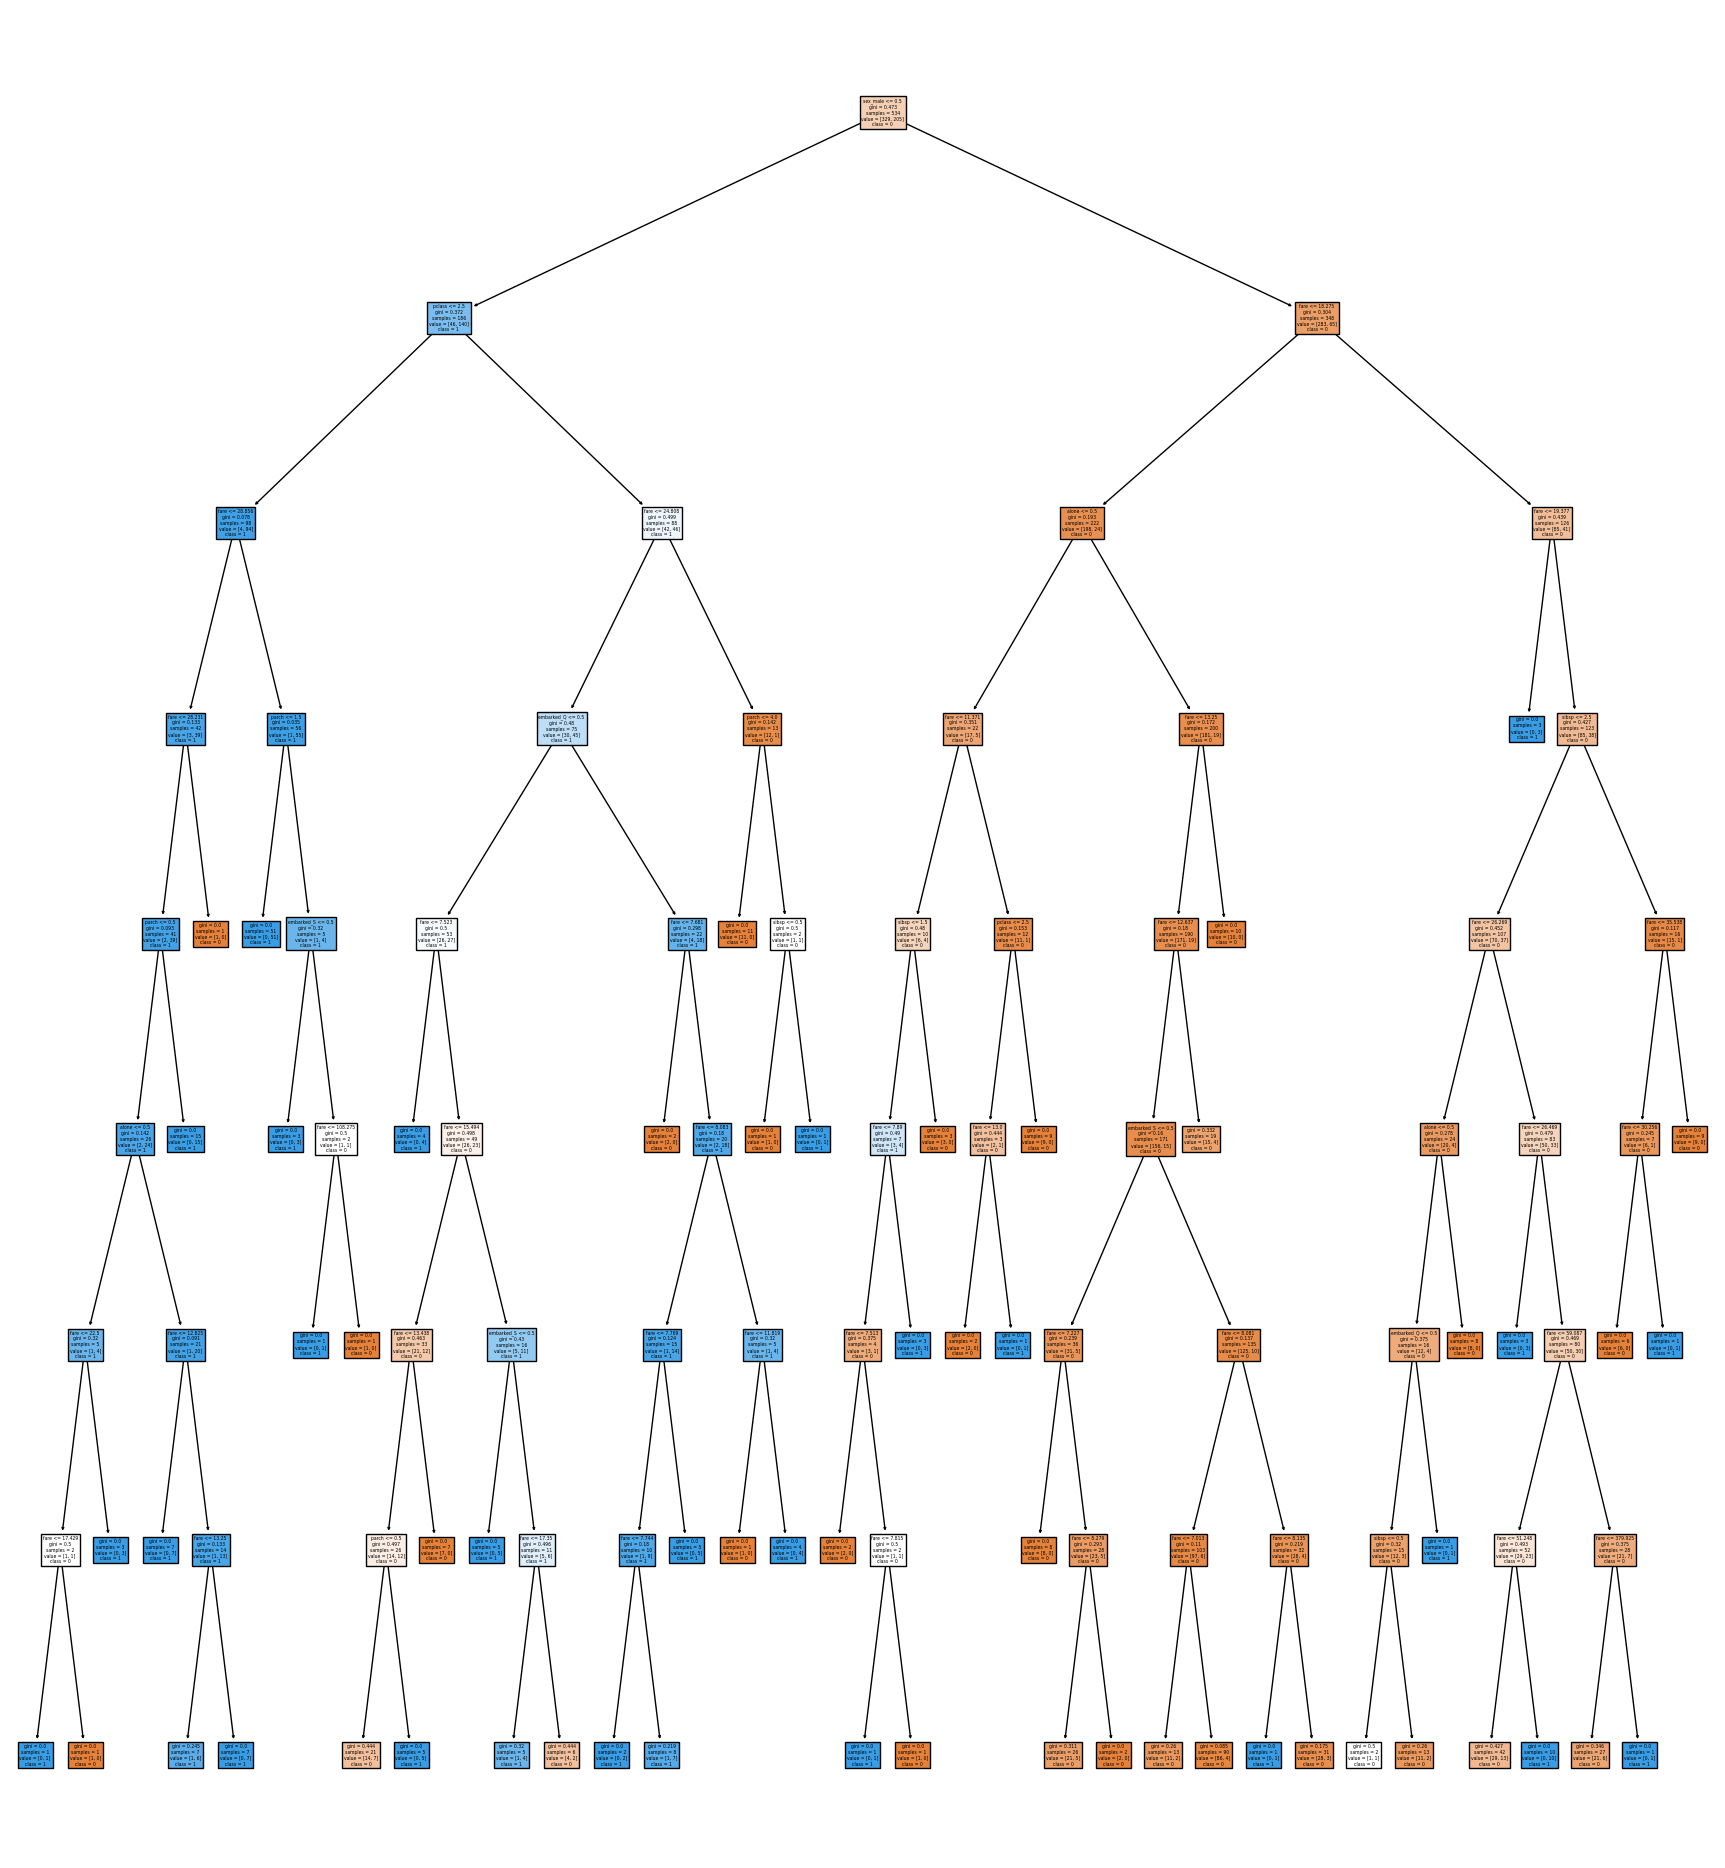

In [171]:
#see the tree that was built
plt.figure(figsize=(22,24))
plot_tree(tree1, #our fitted object
         feature_names=X_train.columns, #puts in our features for the questions
          class_names=clf.classes_, #enters the selected class
          filled=True #colors our leaves and branches based on the class
         )
plt.show()

In [157]:
from sklearn.metrics import classification_report, confusion_matrix

In [158]:
y_train.head()

455    1
380    1
492    0
55     1
243    0
Name: survived, dtype: object

In [162]:
tree1.predict(X_train)[:5]

array(['0', '1', '0', '0', '0'], dtype=object)

In [163]:
y_pred = tree1.predict(X_train)
y_pred[:5]

array(['0', '1', '0', '0', '0'], dtype=object)

In [164]:
#generate confusion matrix!
confusion_matrix(y_train, y_pred)

array([[326,   3],
       [ 49, 156]])

In [165]:
#find labels in our dataset & sort
labels = sorted(y_train.unique())
labels

['0', '1']

In [166]:
#make pretty with df
pd.DataFrame(confusion_matrix(y_train, y_pred),
            index=[label + '_actual'for label in labels],
            columns=[label + '_predict'for label in labels])

,0_predict,1_predict
0_actual,326,3
1_actual,49,156


Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [167]:
#generate classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       329
           1       0.98      0.76      0.86       205

    accuracy                           0.90       534
   macro avg       0.93      0.88      0.89       534
weighted avg       0.91      0.90      0.90       534



Run through steps 2-4 using a different max_depth value.

In [184]:
#create using max_leaf_nodes
tree2 = DecisionTreeClassifier(max_leaf_nodes=2)

#fit
tree2.fit(X_train, y_train)

#transform
tree2.score(X_train, y_train)

0.7921348314606742

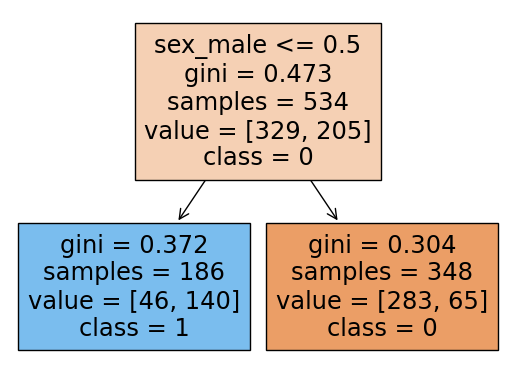

In [185]:
#plot the tree!
plot_tree(tree2, #our fitted object
         feature_names=X_train.columns, #puts in our features for the questions
          class_names=clf.classes_, #enters the selected class
          filled=True #colors our leaves and branches based on the class
         )
plt.show()

In [186]:
#evaluate on validate
tree2.score(X_validate, y_validate)

0.7752808988764045

Takeaway: There is no overfitting. However, this is a pretty bad score compared to my other models. All it does at a depth =2 is divide out the male and females it can determine with 77% accuracy whether someone survived.

In [187]:
train.head()

,passenger_id,survived,pclass,sex,sibsp,parch,fare,embarked,alone,sex_male,embarked_Q,embarked_S
455,455,1,3,male,0,0,7.8958,C,1,1,0,0
380,380,1,1,female,0,0,227.5250,C,1,0,0,0
492,492,0,1,male,0,0,30.5000,S,1,1,0,1
55,55,1,1,male,0,0,35.5000,S,1,1,0,1
243,243,0,3,male,0,0,7.1250,S,1,1,0,1


In [188]:
features = ['sex_male', 'pclass']
features

['sex_male', 'pclass']

In [190]:
X_train[features].head()

,sex_male,pclass
455,1,3
380,0,1
492,1,1
55,1,1
243,1,3


In [191]:
#create
tree3 = DecisionTreeClassifier()

#fit 
#with features
tree3.fit(X_train[features], y_train)

#transform 
#with features
tree3.score(X_train[features], y_train)

0.7921348314606742

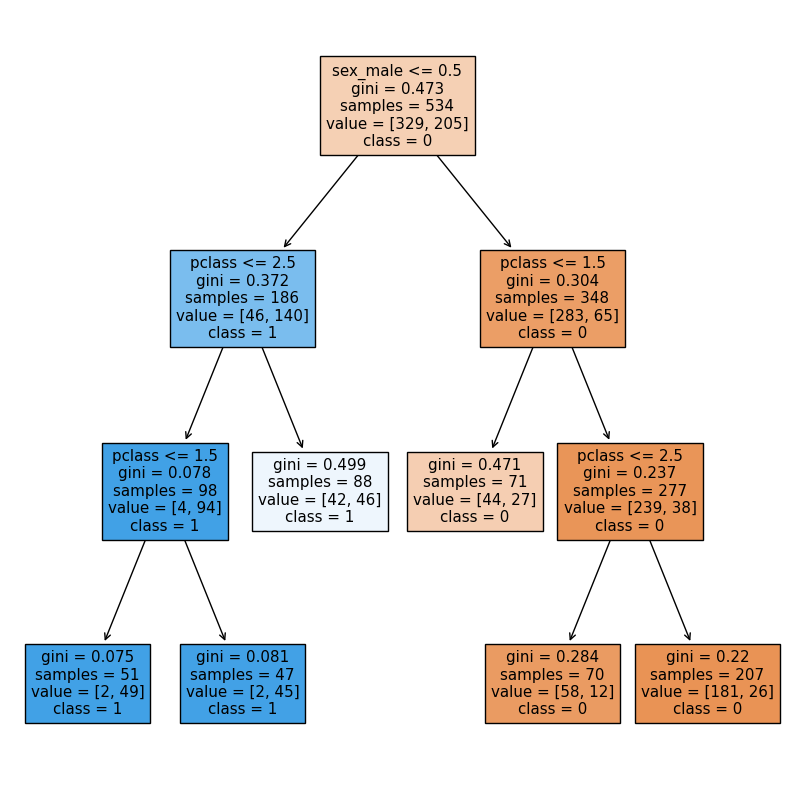

In [192]:
plt.figure(figsize=(10,10))
plot_tree(tree3, #our fitted object
         feature_names=X_train[features].columns, #puts in our features for the questions
          class_names=clf.classes_, #enters the selected class
          filled=True #colors our leaves and branches based on the class
         )
plt.show()

In [193]:
tree3.score(X_validate[features], y_validate)

0.7752808988764045

Which model performs better on your in-sample data? Tree 3

Which model performs best on your out-of-sample data, the validate set? Tree 3

In [194]:
#evaluate on test
tree3.score(X_test[features], y_test)

0.7821229050279329